In [13]:
import cv2
import pandas as pd
import numpy as np

CASC_PATH = './data/haarcascade_frontalface_default.xml'
SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
FILE_PATH = './data/fer2013.csv'

cascade_classifier = cv2.CascadeClassifier(CASC_PATH)

data = pd.read_csv(FILE_PATH)

In [14]:
def format_image(data_pixels):

    # From string to numpy array (gray scale image)
    image = np.fromstring(data_pixels, dtype = np.uint8, sep = ' ').reshape((SIZE_FACE, SIZE_FACE))
    
    # cascade classifier needs some gray padding to find the faces
    (lower_bound, higher_bound) = (75-(SIZE_FACE//2), 75+(SIZE_FACE//2))
    gray_border = np.ones((150, 150), np.uint8)*200
    gray_border[lower_bound:higher_bound, lower_bound:higher_bound] = image
    image = gray_border

    # detect faces
    faces = cascade_classifier.detectMultiScale(image, scaleFactor = 1.3, minNeighbors = 5)

    # None is when we don't find an image
    if not len(faces) > 0:
        return None

    # get biggest area face detected
    (w_max,h_max) = (0,0)
    for (x, y, w, h) in faces:
        if w*h > w_max*h_max:
            (x_max,y_max,w_max,h_max) = (x,y,w,h)

    image = image[y_max:(y_max + h_max), x_max:(x_max + w_max)]
    
    # Resize image to network size and normalize values
    image = cv2.resize(image, (SIZE_FACE, SIZE_FACE), interpolation = cv2.INTER_CUBIC) / 255.
       
    return image



In [15]:

data["images"] = data["pixels"].apply(lambda x: format_image(x))

data = data.drop(["pixels", "Usage"], axis=1).dropna(axis=0).reset_index(drop=True)


In [16]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 2 columns):
emotion    13974 non-null int64
images     13974 non-null object
dtypes: int64(1), object(1)
memory usage: 218.4+ KB


,emotion,images
0,0,"[[0.78431372549, 0.772549019608, 0.77254901960..."
1,2,"[[0.78431372549, 0.78431372549, 0.78431372549,..."
2,6,"[[0.78431372549, 0.764705882353, 0.76470588235..."
3,2,"[[0.78431372549, 0.78431372549, 0.76862745098,..."
4,3,"[[0.286274509804, 0.207843137255, 0.2, 0.29803..."


In [19]:
#Save file
data.to_hdf('./data/fer2013.h5', 'data')


C:\Joca\Anaconda3\lib\site-packages\pandas\core\generic.py:1282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['images']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


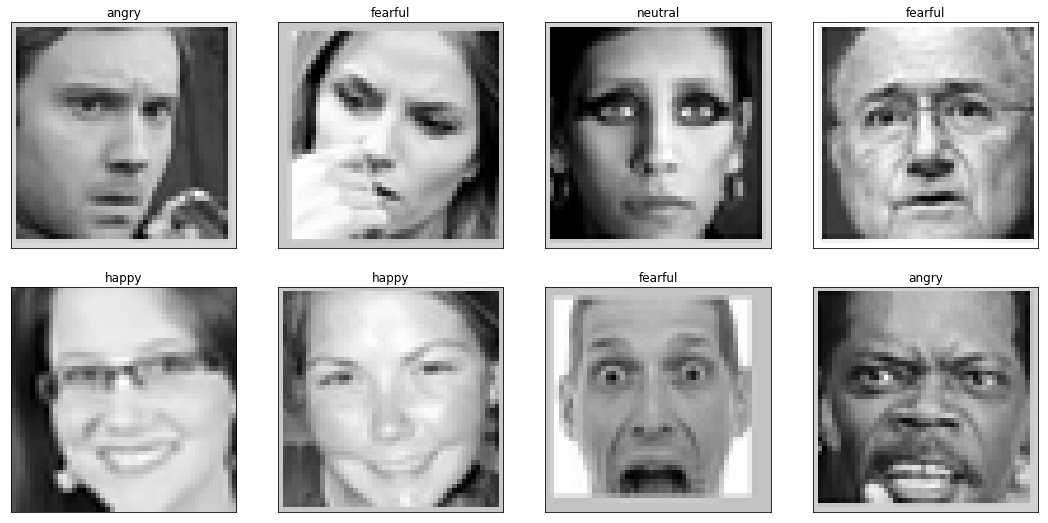

In [22]:
data = pd.read_hdf('./data/fer2013.h5','data')

from matplotlib import pyplot as plt

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

rows = 2
columns = 4

f, axarr = plt.subplots(rows,columns,figsize=(15,7.5))
f.tight_layout()

for i in range(0,rows):
    for j in range(0,columns):
        axarr[i][j].imshow(data["images"].iloc[i*columns+j], cmap = 'gray')
        axarr[i][j].set_title(EMOTIONS[data["emotion"].iloc[i*columns+j]])

plt.setp(axarr, xticks=[], yticks=[]) # to hide tick values on X and Y axis
plt.show()